In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm 
from sklearn.utils import shuffle
from IPython import display
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import nibabel as nib
import time
import pickle
import gc
import seaborn as sns
import pathlib
import hgg_utils as hu

### Utility function for printing

In [3]:
def plot_masks(i):

    ds_vals = [1,2,4,8]
    preds = []

    for model, ds in zip( models, ds_vals):

        p = model.predict(four_channel_scan[i:i+1,:,:,:])

        #threshold the predicted mask
        p[np.where(p < 0.5)] = 0
        p[np.where(p >= 0.5)] = 1

        preds.append(p)
    
    plt.figure(1, figsize=(10,10))

    #plot predicted mask ds 1
    plt.subplot(331)
    plt.title("ds 1 pred".format(ds))
    plt.imshow(preds[0][0,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)

    #plot predicted mask ds 2
    plt.subplot(332)
    plt.title("ds 2 pred".format(ds))
    plt.imshow(preds[1][0,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)

    #plot predicted mask ds 4
    plt.subplot(333)
    plt.title("ds 4 pred".format(ds))
    plt.imshow(preds[2][0,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)

    #plot predicted mask ds 8
    plt.subplot(334)
    plt.title("ds 8 pred".format(ds))
    plt.imshow(preds[3][0,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)

    #plot ground truth mask
    plt.subplot(335)
    plt.title("mask")
    plt.imshow(mask[i,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)
    
    #plot brain
    plt.subplot(336)
    plt.title("flair of input")
    plt.imshow(four_channel_scan[i,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)
    
    

    plt.tight_layout()
    plt.show()

# Open some data

#### Load a brain

In [17]:
paths = pathlib.Path().cwd().parent.parent / "MICCAI_BraTS_2019_Data_Training" / "MICCAI_BraTS_2019_Data_Training" / "normalized_hgg"
a_brain_path = [x for x in paths.iterdir()][0]
    
four_channel_scan = hu.reshape_tensor_with_slices_first(
                                    hu.get_a_multimodal_tensor( 
                                                a_brain_path 
                                    )[0]
            )

#### Load a mask

In [18]:
mask_path = pathlib.Path().cwd().parent.parent / "MICCAI_BraTS_2019_Data_Training" / "MICCAI_BraTS_2019_Data_Training" / "HGG"
a_mask_path = [x for x in mask_path.iterdir()][0]

mask =  hu.reshape_tensor_with_slices_first(
                        hu.convert_mask_to_binary_mask(
                             hu.get_a_mask_tensor( a_mask_path )

                       )
)

# Our data consists of 4 modality input and 1 channel output (mask)

#### Look at a slice of the brain in the flair modality

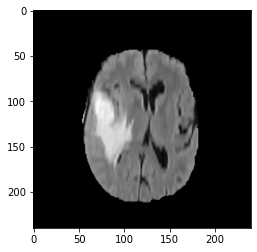

In [19]:
plt.imshow(four_channel_scan[80,:,:,0].T, cmap="Greys_r")

#### Look at the corresponding slice of the mask

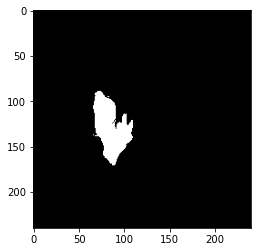

In [20]:
plt.imshow(mask[80,:,:,0].T, cmap="Greys_r")

As you can see above, the mask shows where the tumor exists in the given slice of a brain.

# Load models

Now we will load the models with which we ran the 4 experiments. DS 1 is the full U-net, DS 2 has half the filters, DS 4 has a quarter of the filters, and DS 8 has an eighth of the filters. Less filters means less VRAM is required during GPU accelerated training. Let's see how the trained models compare.

In [22]:
ds_vals = [1, 2, 4, 8]

models = []

for i, ds in enumerate(ds_vals):
    
    model_path = "../unet_ds_{}.JSON".format(ds)
    weights_path = "../ds_{}_run_{}_model_weights.h5".format(ds, 1)

    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights(weights_path)
    
    models.append(model)

# Visualize predicted slices with models

Look at the predictions for the mask, ie. where the tumor is located, for different slices.

### Slice 50

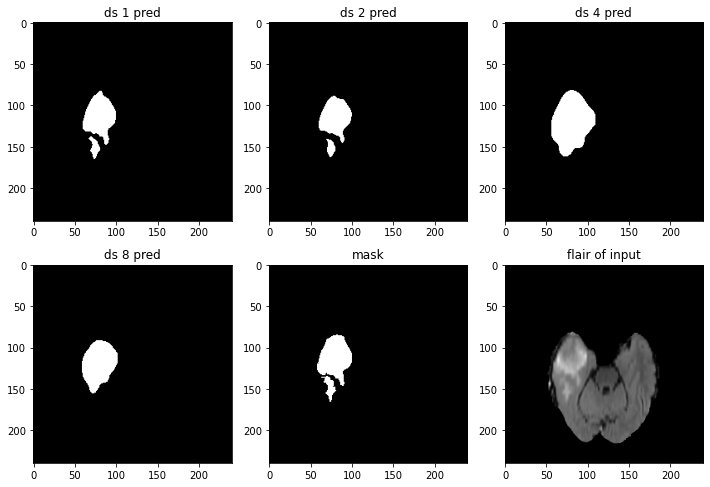

In [23]:
plot_masks(50)

### Slice 60

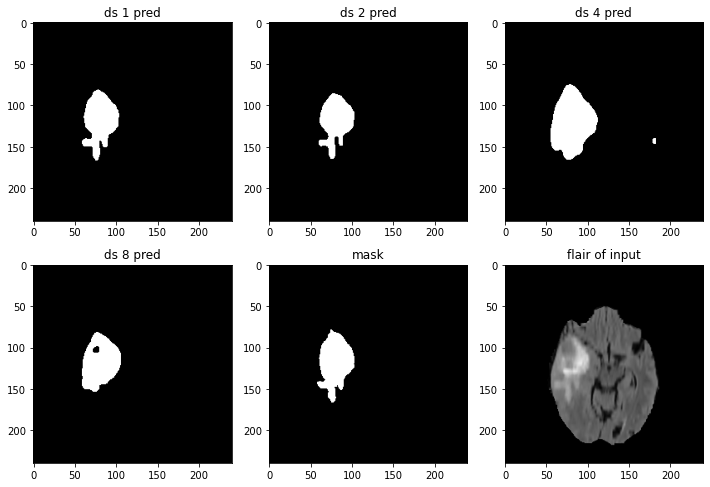

In [24]:
plot_masks(60)

### Slice 70

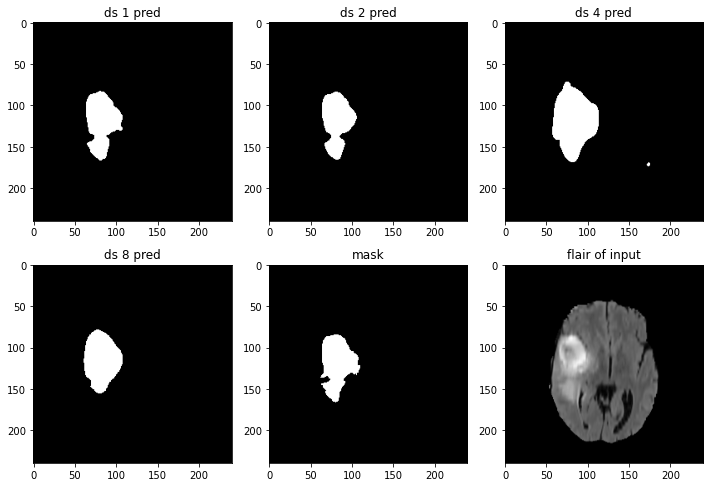

In [25]:
plot_masks(70)

### Slice 90

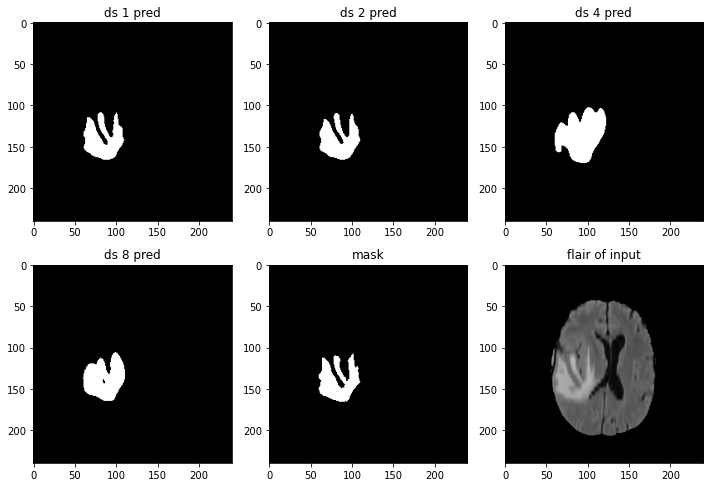

In [26]:
plot_masks(90)

# Visualize general performance of pretrained models

Now we will look at the performance of these models over the testing set. Above we were looking at a single run of each of the experiments on a single brain for the predictions. Here we are looking at the average performance of all 5 runs of each experiment on the entire testing set.

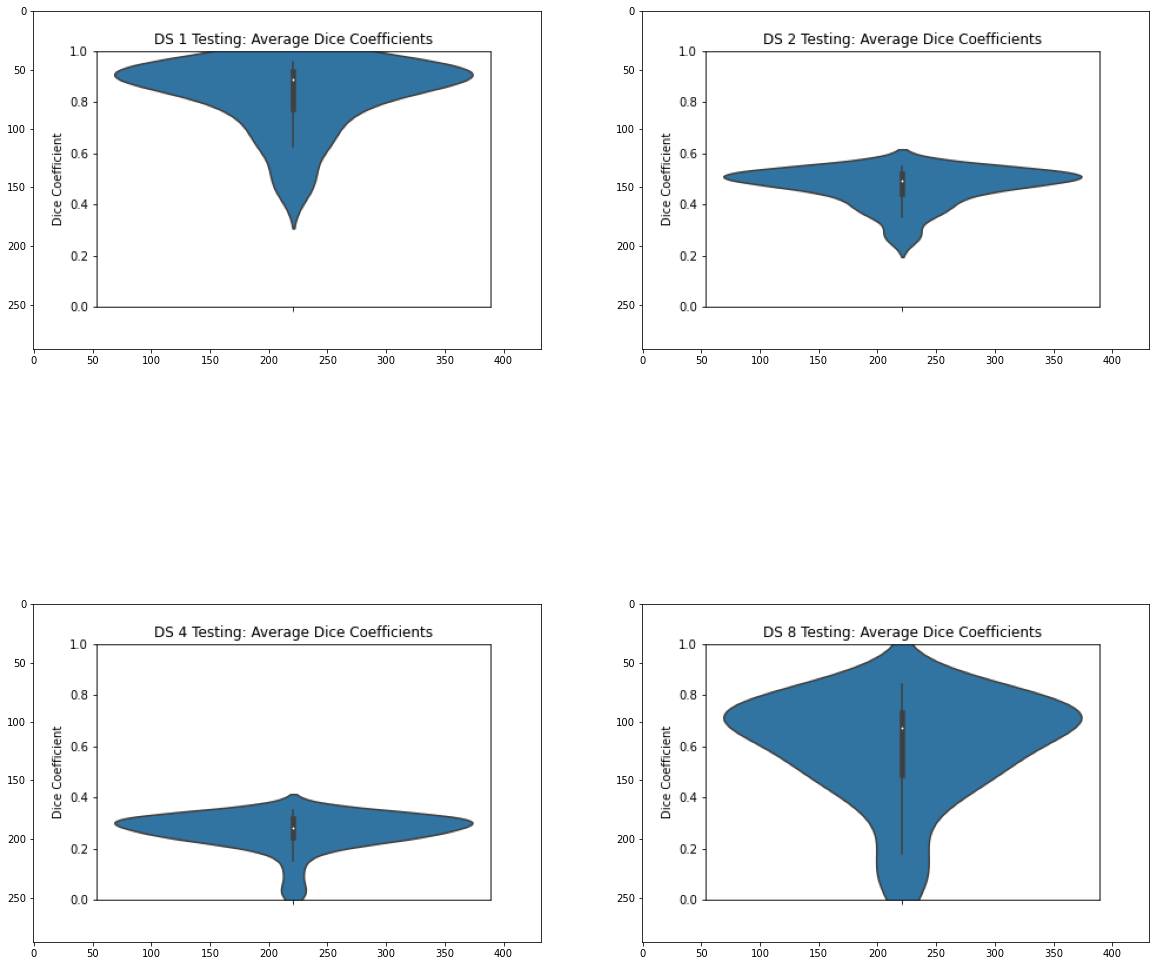

In [16]:
fig, img = plt.subplots(2,2, figsize=(20,20) )

img[0,0].imshow(plt.imread("../ds_1_testing_violin_plot.png"))
img[0,1].imshow(plt.imread("../ds_2_testing_violin_plot.png"))
img[1,0].imshow(plt.imread("../ds_4_testing_violin_plot.png"))
img[1,1].imshow(plt.imread("../ds_8_testing_violin_plot.png"))


# Discussion

It is clear to see that the full U-net (DS 1) learned the best. In general, DS 8 performed the second best, followed by DS 2, then DS 4. However, not every run of the models learned properly, which has impacted the results. Perhaps more runs should have been performed for each experiment to generate more definitive results. Also, maybe having less filters makes a model more succeptible to having bad weight initializations prevent learning. 

It appears that having less filters does worsen performance, but future work could train the models longer to see if models with less filters converge to similar performance as DS 1.